📚 Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras.callbacks import (
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Flatten,
    Dense,
    Add,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

⚙️ Training Parameters

In [ ]:
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean helps improve accuracy
subtract_pixel_mean = True

# ResNet depth/variant configuration
n = 3
version = 1  # ResNet v1 or v2

# Depth rule: ResNet v1 -> 6n+2, ResNet v2 -> 9n+2
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

model_type = f"resnet{depth}v{version}"

📥 Load CIFAR-10 Dataset

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


⚖️ Normalize Data

In [ ]:
input_shape = x_train.shape[1:]

# Scale pixel values to [0,1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Optionally subtract pixel mean
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print("y_train shape:", y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


🔢 One-Hot Encode Labels

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

🔧 ResNet Building Block

In [ ]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    """
    2D Convolution-Batch Normalization-Activation stack builder.

    Args:
        inputs (tensor): input tensor
        num_filters (int): number of filters
        kernel_size (int): convolution kernel size
        strides (int): convolution strides
        activation (str): activation function
        batch_normalization (bool): whether to include batch norm
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    Returns:
        tensor: output tensor
    """
    conv = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=l2(1e-4),
    )

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

🏗️ ResNet V1 (6n+2)

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """
    ResNet V1 model builder (6n+2 layers).
    """
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (e.g 20, 32, 44)")

    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # Stacks of residual blocks
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # First layer of each stack (except first)
                num_filters *= 2
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:
                # Projection shortcut to match dimensions
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = Add()([x, y])
            x = Activation("relu")(x)

    # Classification head
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation="softmax", kernel_initializer="he_normal")(
        x
    )

    model = Model(inputs=inputs, outputs=outputs)
    return model

🏗️ ResNet V2 (9n+2)

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    """
    ResNet V2 model builder (9n+2 layers).
    """
    if (depth - 2) % 9 != 0:
        raise ValueError("depth should be 9n+2 (e.g 56, 110)")

    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)

    x = resnet_layer(inputs=inputs, num_filters=num_filters_in, conv_first=True)

    # Stacks of residual blocks
    for stack in range(3):
        for res_block in range(num_res_blocks):
            activation = "relu"
            batch_normalization = True
            strides = 1

            if stack == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:
                    strides = 2  # downsample

            # Bottleneck block
            y = resnet_layer(
                inputs=x,
                num_filters=num_filters_in,
                strides=strides,
                activation=activation,
                batch_normalization=batch_normalization,
                conv_first=False,
            )
            y = resnet_layer(inputs=y, num_filters=num_filters_in, conv_first=False)
            y = resnet_layer(
                inputs=y, num_filters=num_filters_out, kernel_size=1, conv_first=False
            )
            if res_block == 0:
                # Projection shortcut
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters_out,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = Add()([x, y])
        num_filters_in = num_filters_out

    # Classification head (BN-ReLU before pooling)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation="softmax", kernel_initializer="he_normal")(
        x
    )

    model = Model(inputs=inputs, outputs=outputs)
    return model


# Choose ResNet version
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.summary()
print(model_type)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 16)     │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 16)     │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 16)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 16)     │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 16)     │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 16)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 16)     │          2,320 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 16)     │              0 │ activation[0][0],      │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 16)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 16)     │          2,320 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 16)     │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 16)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 16)     │          2,320 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 16)     │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 274,442 (1.05 MB)

 Trainable params: 273,066 (1.04 MB)

 Non-trainable params: 1,376 (5.38 KB)

Resnet20v1


⚙️ Compile the Model

In [ ]:
def lr_schedule(epoch):
    """
    Learning rate schedule:
    - Start with 1e-3
    - Decay at epochs 80, 120, 160, 180
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print("Learning rate: ", lr)
    return lr


model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=lr_schedule(0)),
    metrics=["accuracy"],
)

Learning rate:  0.001


🚀 Train the Model

In [ ]:
checkpoint = ModelCheckpoint(
    filepath=f"model.cifar10_{model_type}.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6
)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation
if not data_augmentation:
    print("Not using data augmentation")
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=callbacks,
    )
else:
    print("Using real-time data augmentation")
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
    )
    datagen.fit(x_train)

    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        validation_data=(x_test, y_test),
        epochs=epochs,
        verbose=1,
        steps_per_epoch=x_train.shape[0] // batch_size,
        callbacks=callbacks,
    )

Using real-time data augmentation
Learning rate:  0.001
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4039 - loss: 1.8240
Epoch 1: val_accuracy improved from -inf to 0.57870, saving model to /content/drive/My Drive/model.cifar10_Resnet20v1.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 78s 34ms/step - accuracy: 0.4039 - loss: 1.8238 - val_accuracy: 0.5787 - val_loss: 1.2976 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 2/200
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.5938 - loss: 1.1188

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.57870
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5938 - loss: 1.1188 - val_accuracy: 0.5646 - val_loss: 1.3302 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 3/200
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6246 - loss: 1.2133
Epoch 3: val_accuracy improved from 0.57870 to 0.64520, saving model to /content/drive/My Drive/model.cifar10_Resnet20v1.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.6247 - loss: 1.2132 - val_accuracy: 0.6452 - val_loss: 1.1968 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 4/200
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5938 - loss: 1.1623
Epoch 4: val_accuracy did not improve from 0.64520
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5938 - loss: 1.1623 - val_accuracy: 0.6432 - val_loss: 1.2026 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 5/200
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6925 - loss: 1.0431
Ep

💾 Load Best Saved Model

In [ ]:
model.load_weights(f"model.cifar10_{model_type}.keras")

📊 Evaluate the Model

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9088 - loss: 0.4484
Test loss: 0.4546690285205841
Test accuracy: 0.9088000059127808


📈 Plot Training Curves

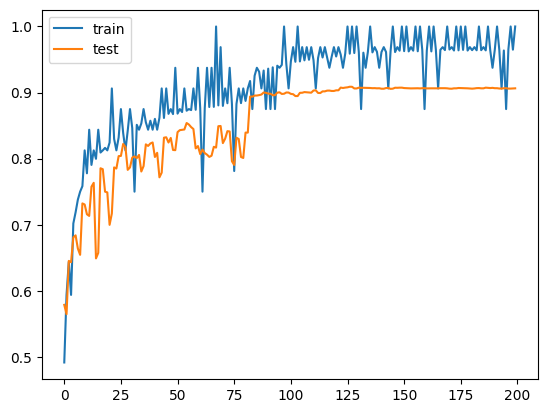

In [ ]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.legend()
plt.show()

🔮 Visualize Model Predictions

In [ ]:
# Generate predictions
y_hat = model.predict(x_test)

cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


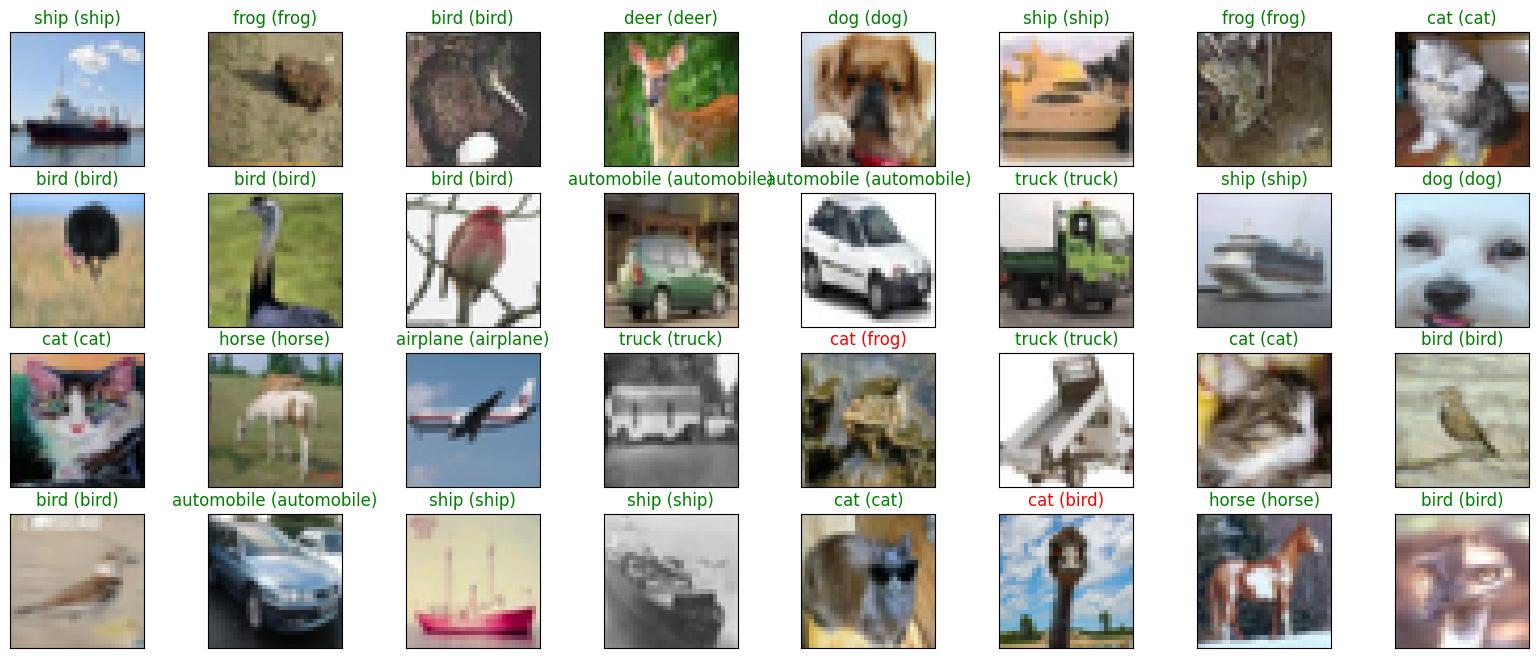

In [ ]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[idx])
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title(
        f"{cifar10_labels[pred_idx]} ({cifar10_labels[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )